# An analyse of sales of Ebay-Shop


In [1]:
import os
import re
import sys
import time
import warnings
import subprocess
import shutil

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.0f' % x) # show only decimal number 

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from PyPDF2 import PdfMerger

warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('classic')
plt.rcParams['grid.color'] = (0.9, 0.9, 0.9, 0.1)   

In [2]:
class CFG:
    
    shop_name='buddentown'
    data_file_path='./data'
    path=f'Verkaufsanalyse_{shop_name}'
    num_bestsellings=30
    email=''
    real_sales=True
    feedback_quote=2.5
    shop_category='Haushalt'
    german_stopwords=stopwords.words('german')
    more_stopwords=['for','ideal','satz','forum','BOX','BIT','GBA','SDS','GAL','GSR','PLUS','GST','GKS','TPN','EUR','set','neue','alte','Akku','Watt','GSA','teilig']

    
    column_names = { 'card__item':'Artikelname',
                     'card__price':'Artikelpreis',
                     'tablescraper-selected-row':'Zeitraum',
                     'card__item 2':'Artikelnummer',
                     'card__item href':'Artikel_link'}
    categories = {  'Werkzeug':{'bins':200,'y_max_rate':0.2,'x_max_rate':3},
                    'Technik':{'bins':250,'y_max_rate':0.1,'x_max_rate':3},
                    'Haushalt':{'bins':250,'y_max_rate':0.5,'x_max_rate':5},}
    
    @staticmethod
    def get_text_position(shop_category):
    
        if shop_category=='Haushalt':
            return 200

        elif shop_category=='Werkzeug': 
            return 500

        elif shop_category=='Technik': 
            return 300

        else: 
            return 400

In [3]:
def create_last6months_table(shop):
    """
    Creates a table containing data from the last six months for a given shop.
    """
    
    # Read the CSV file and select relevant columns
    df6 = pd.read_csv(f"{CFG.data_file_path}/{shop}6.csv", usecols=['card__item',
                                                 'card__item 2',
                                                 'card__item href',
                                                 'card__price',
                                                 'tablescraper-selected-row'])
    
    # Rename column CFG.column_names
    df6.rename(CFG.column_names, inplace=True, axis=1)  
    
    # Select only the data from the last six months
    df6 = df6.loc[df6['Zeitraum'].isin(['Letzter Monat', 'Letzte 6 Monate']), :]
    
    return df6


In [4]:
def create_6_12months_table(shop):
    """
    Create a table for the last 6-12 months of data for a given shop.

    """
    # Read the data from the CSV file, selecting specific columns
    df12 = pd.read_csv(f"./data/{shop}12.csv", usecols=['card__item', 'card__price', 'tablescraper-selected-row'])

    # Create additional columns to conform with the table for the last six months
    df12['card__item href'] = np.nan
    df12['card__item 2'] = np.nan

    # Rename columns
    df12.rename(CFG.column_names, inplace=True, axis=1)

    # Filter the data for the last 6-12 months
    df6_12 = df12.loc[df12['Zeitraum'] == 'Letztes Jahr', :]


    return df6_12

In [5]:
# some helper functions for formatting table 
def convert_datatype(df):
    
    df['Preis_EUR'] = df.Artikelpreis.str.split(expand=True)[1] # remove EUR
    df['Preis_EUR'] = df.Preis_EUR.str.replace('$','')
    df['Preis_EUR'] = df.Preis_EUR.str.replace('.','')
    df['Preis_EUR'] = df.Preis_EUR.str.replace(',','.')
    df['Preis_EUR'] = df.Preis_EUR.astype(float)
    df.drop('Artikelpreis',inplace=True,axis =1)
    return df

def split_number(text):
    
    match = re.search(r'[0-9]{12}',str(text))
    return match.group() if match else None

def remove_item_number(text):
    
    """ function to remove item number from description"""
    text = str(text)
    pattern1 = r'[0-9]{12}'
    pattern2 = r'\(Nr\.'
    text = re.sub(r'\)','',text)    # remove ')'
    text = re.sub(pattern1,'',text) # remove item number
    text = re.sub(pattern2,'',text) # remove (Nr .
    
    return text

def fill_nan(df):
    
    df['Artikelnummer_temp'] = df['Artikelname'].apply(split_number)
    nan_index = df[df['Artikelnummer'].isnull()].index
    df.loc[nan_index,'Artikelnummer']=df.loc[nan_index,'Artikelnummer_temp'] # fill item number
    df.loc[nan_index,'Artikel_link'] = 'https://www.ebay.de/itm/'+ \
                                        df.loc[nan_index,'Artikelnummer'] # fill links
    df.drop('Artikelnummer_temp',axis = 1, inplace= True)
    df.dropna(inplace=True)
    
    return df


In [6]:
def create_full_table(shop):
    
    """ create full table  for a given shop."""
    
    df6 = create_last6months_table(shop)
    df6_12 = create_6_12months_table(shop)
    df = pd.concat([df6,df6_12],ignore_index=True) # concatenate to full data
    
    return df
full_df = create_full_table(CFG.shop_name)


,Artikelname,Artikelnummer,Artikel_link,Artikelpreis,Zeitraum
0,Geräteleiste mit 4x Besenhalter Wand Halterung...,373938420968,https://www.ebay.de/itm/373938420968,"EUR 10,38",Letzter Monat
1,Wand Müllsackständer 120L Gelber Sack Halter M...,374007630100,https://www.ebay.de/itm/374007630100,"EUR 17,31",Letzter Monat
2,GAH Dreikantschlüssel für Absperrpfosten mit D...,302021223819,https://www.ebay.de/itm/302021223819,"EUR 8,03",Letzter Monat
3,Steckdosen Thermostat 5-30 C für Infrarot Heiz...,372695091404,https://www.ebay.de/itm/372695091404,"EUR 20,96",Letzter Monat
4,12 Shotgläser Schnapsgläser 2cl standfest bunt...,234858773534,https://www.ebay.de/itm/234858773534,"EUR 16,30",Letzter Monat
...,...,...,...,...,...
50533,Blumat Bewässerungssystem Wasserspender für Zi...,NaN,NaN,"EUR 32,84",Letztes Jahr
50534,6 Whiskey Gläser Whisky Glas Trink Becher Scot...,NaN,NaN,"EUR 13,99",Letztes Jahr
50535,H-Form Balkonkastenhalter Blumenkasten Halteru...,NaN,NaN,"EUR 4,99",Letztes Jahr
50536,2x Kubus Pflanzkübel Blumentopf Blumenkübel Pf...,NaN,NaN,"EUR 59,90",Letztes Jahr


In [7]:
def format_table(df):
    
    df = convert_datatype(df)
    df = fill_nan(df) # fill nan value in item number and item link column
    df['Artikelname'] = df['Artikelname'].apply(remove_item_number) # remove item number from item description
    df.Artikelnummer=df.Artikelnummer.astype(int) # convert item number to type int
    print(f'{df.isnull().sum().sum()} NaN value(s) after dropna')

    return df
formated_table = format_table(full_df)


0 NaN value(s) after dropna


,Artikelname,Artikelnummer,Artikel_link,Zeitraum,Preis_EUR
0,Geräteleiste mit 4x Besenhalter Wand Halterung...,373938420968,https://www.ebay.de/itm/373938420968,Letzter Monat,10
1,Wand Müllsackständer 120L Gelber Sack Halter M...,374007630100,https://www.ebay.de/itm/374007630100,Letzter Monat,17
2,GAH Dreikantschlüssel für Absperrpfosten mit D...,302021223819,https://www.ebay.de/itm/302021223819,Letzter Monat,8
3,Steckdosen Thermostat 5-30 C für Infrarot Heiz...,372695091404,https://www.ebay.de/itm/372695091404,Letzter Monat,21
4,12 Shotgläser Schnapsgläser 2cl standfest bunt...,234858773534,https://www.ebay.de/itm/234858773534,Letzter Monat,16
...,...,...,...,...,...
50533,Blumat Bewässerungssystem Wasserspender für Zi...,373869294139,https://www.ebay.de/itm/373869294139,Letztes Jahr,33
50534,6 Whiskey Gläser Whisky Glas Trink Becher Scot...,373825937324,https://www.ebay.de/itm/373825937324,Letztes Jahr,14
50535,H-Form Balkonkastenhalter Blumenkasten Halteru...,304430034393,https://www.ebay.de/itm/304430034393,Letztes Jahr,5
50536,2x Kubus Pflanzkübel Blumentopf Blumenkübel Pf...,373805090373,https://www.ebay.de/itm/373805090373,Letztes Jahr,60


In [28]:
#some helper functions
def create_revenue_columns(df):
    
    df['Umsatz/Monat'] = df['Verkäufe letztes Monats in Stück']*df['Preis_EUR']
    df['Umsatz/6_Monate'] = df['Durchschnittliche Verkäufe letzter 6 Monate']*5*df['Preis_EUR']+df['Umsatz/Monat']
    df['Umsatz/12_Monate'] = df['Durchschnittliche Verkäufe letzter 12 Monate']*11*df['Preis_EUR']+df['Umsatz/Monat']
    return df

def change_datatype_to_int(df):
    
    df.fillna(0,inplace=True)
    columns=['Verkäufe letztes Monats in Stück','Durchschnittliche Verkäufe letzter 6 Monate',
           'Durchschnittliche Verkäufe letzter 12 Monate','Umsatz/Monat','Umsatz/6_Monate','Umsatz/12_Monate']
    for column in columns:
        df[column]=df[column].round().astype(int)
    return df


    
best_selling_revenue = create_revenue_columns(best_selling)

In [32]:
def highest_demand_products(df,num):
    
    letzter_monat = df.loc[df['Zeitraum'].isin(['Letzter Monat']),'Artikel_link'].value_counts()
    letzte_6_monate= df.loc[df['Zeitraum'].isin(['Letzte 6 Monate']),'Artikel_link'].value_counts()
    letzte_6_12_monate = df.loc[df['Zeitraum'].isin(['Letztes Jahr']),'Artikel_link'].value_counts()

    best_sellings = pd.concat([letzter_monat,letzte_6_monate,letzte_6_12_monate],axis=1)
    best_sellings.columns.values[0]='Verkäufe letztes Monats in Stück'
    best_sellings.columns.values[1]='Verkäufe vor 1-6 Monat in Stück'
    best_sellings.columns.values[2]='Verkäufe vor 6-12 Monat in Stück'

    best_sellings['Durchschnittliche Verkäufe letzter 6 Monate' ]=best_sellings['Verkäufe vor 1-6 Monat in Stück']/5 
    best_sellings['Durchschnittliche Verkäufe vor 6-12 Monat']=best_sellings['Verkäufe vor 6-12 Monat in Stück']/6 
    best_sellings['Durchschnittliche Verkäufe letzter 12 Monate']=(best_sellings['Verkäufe vor 1-6 Monat in Stück']\
                                                        + best_sellings['Verkäufe vor 6-12 Monat in Stück'])/11

    best_sellings= best_sellings.iloc[:num,:]
    df =  df.loc[:,['Artikelname','Artikel_link','Preis_EUR','Artikelnummer']]. drop_duplicates().set_index('Artikel_link')                                          
    
    best_sellings= best_sellings.reset_index().merge(df,left_on= best_sellings.index, right_on='Artikel_link')
   
    best_sellings_index= best_sellings['Artikel_link'].drop_duplicates().index
    
    best_sellings = best_sellings.loc[best_sellings_index,:].reset_index(drop = True)
    best_sellings = create_revenue_columns(best_sellings)
    best_sellings = change_datatype_to_int(best_sellings)
    return best_sellings

best_sellings = highest_demand_products(formated_table,CFG.num_bestsellings) 
best_sellings

,Artikel_link,Verkäufe letztes Monats in Stück,Verkäufe vor 1-6 Monat in Stück,Verkäufe vor 6-12 Monat in Stück,Durchschnittliche Verkäufe letzter 6 Monate,Durchschnittliche Verkäufe vor 6-12 Monat,Durchschnittliche Verkäufe letzter 12 Monate,Artikelname,Preis_EUR,Artikelnummer,Umsatz/Monat,Umsatz/6_Monate,Umsatz/12_Monate
0,https://www.ebay.de/itm/373937933433,88,366,283,73,47,59,Lackspray RAL Acryl,10,373937933433,895,4617,7495
1,https://www.ebay.de/itm/232279934737,69,40,33,8,6,7,Auto Verbandskasten Verbandstasche,8,232279934737,537,848,1105
2,https://www.ebay.de/itm/303052063711,50,107,93,21,16,18,Stahl Rankhilfe Obelisk,16,303052063711,778,2443,3890
3,https://www.ebay.de/itm/304430034393,48,82,53,16,9,12,Form Balkonkastenhalter Blumenkasten,5,304430034393,240,649,913
4,https://www.ebay.de/itm/232291848140,41,45,35,9,6,7,Ersatz Kolben Hand,22,232291848140,886,1858,2615
5,https://www.ebay.de/itm/371474696872,36,138,147,28,24,26,Kindersitz Auto Sitz,11,371474696872,395,1911,3525
6,https://www.ebay.de/itm/234135245821,36,157,479,31,80,58,Set LED Kerze,14,234135245821,513,2752,9583
7,https://www.ebay.de/itm/372695589382,34,98,188,20,31,26,Pfostenkappe Edelstahl Stahl,10,372695589382,324,1259,3053
8,https://www.ebay.de/itm/304174144881,32,116,147,23,24,24,Erdanker Unkrautvlies Befestigung,16,304174144881,508,2350,4685
9,https://www.ebay.de/itm/302213467639,31,35,376,7,63,37,Foetsie Elektrische Fliegenklatsche,13,302213467639,404,861,5764


In [33]:
def write_best_selling_to_file(df):
    
    if os.path.exists(CFG.path):
        shutil.rmtree(CFG.path)
    os.makedirs(CFG.path)
    
    df = change_datatype_to_int(df)
    df.to_csv(f'{CFG.path}/{CFG.shop_name}_{CFG.num_bestsellings}_bestsellings.csv')
    
write_best_selling_to_file(best_selling_revenue)    

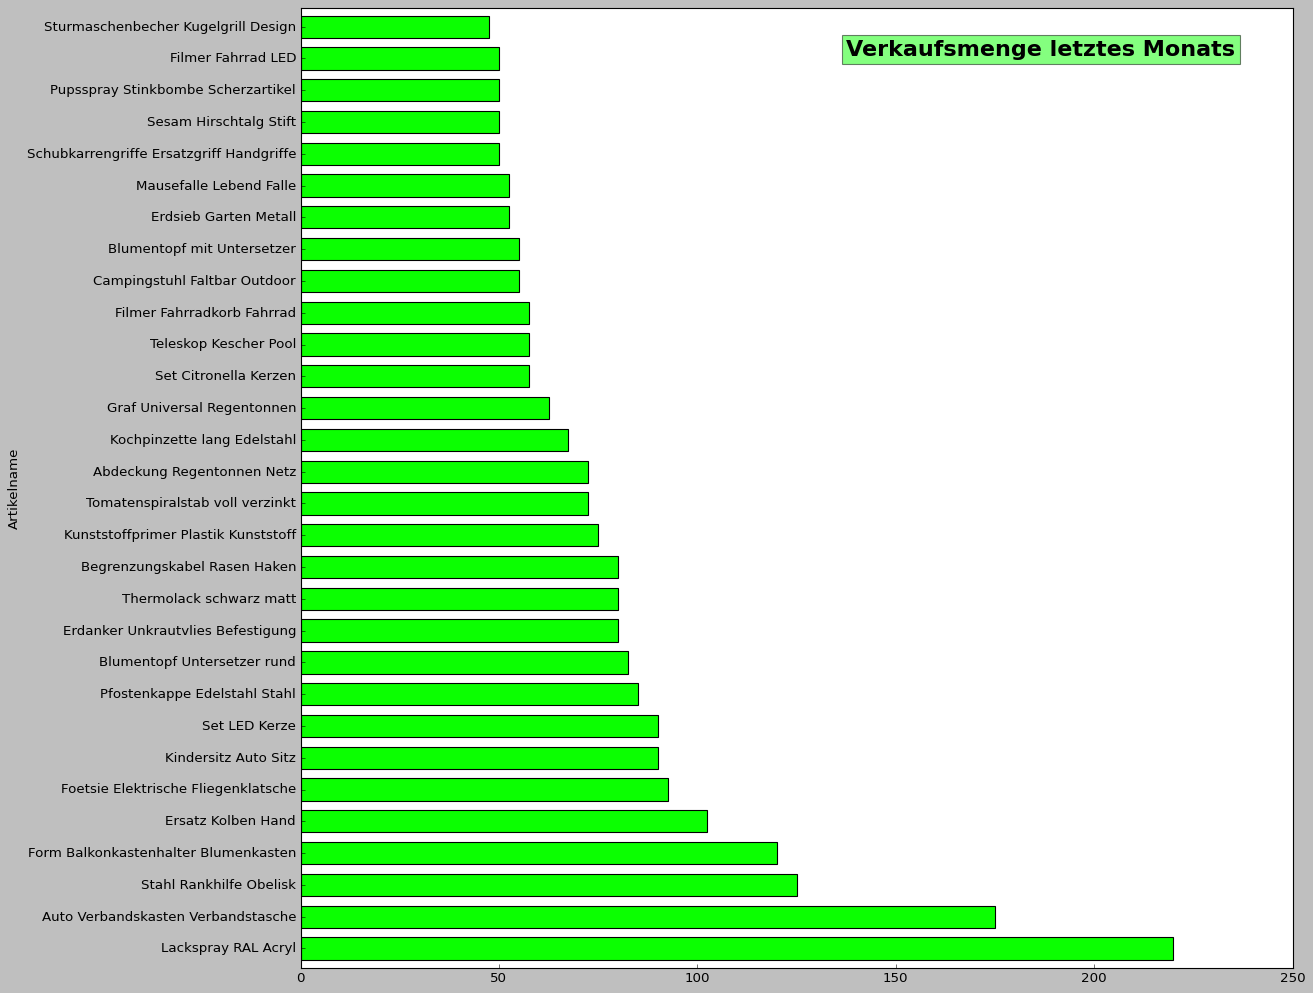

In [34]:
def plot_monthly_sales(df,true_sales=True):
    
    bestsellings = df.loc[df['Zeitraum']=='Letzter Monat','Artikelname']\
        .value_counts()[:CFG.num_bestsellings]
                       
    bestsellings = bestsellings * CFG.feedback_quote if true_sales else bestsellings
    ax = bestsellings.plot(kind='barh',
                          figsize=(16,15),
                          color="#0bff01",
                          width=0.7,
                          edgecolor='black'
                          )
    plt.tick_params(
                    axis='both',       # changes apply to the x and y-axis
                    which='both',      # both major and minor ticks are affected
                    right=False,       # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off

                        )
    ax.text(0.55, 0.95, 'Verkaufsmenge letztes Monats', fontdict={'fontsize':20, 'fontweight' :'bold'},
            transform=ax.transAxes, bbox=dict(facecolor='#0bff01', alpha=0.5)
           )


    plt.savefig(f'{CFG.path}/Verkaufsmenge letztes Monates(1).pdf',bbox_inches='tight')
    
plot_monthly_sales(full_df)

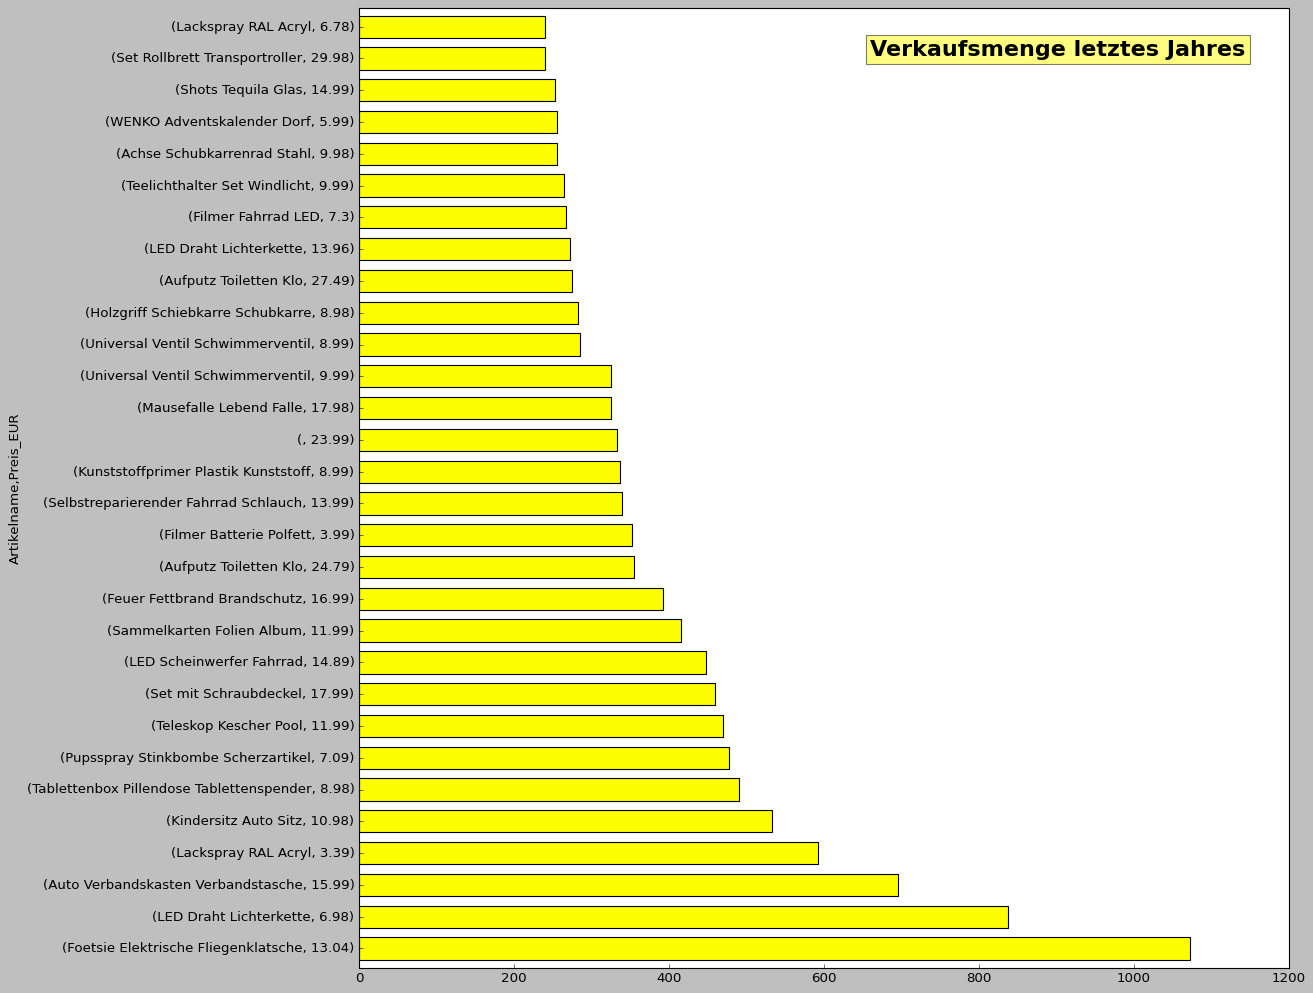

In [35]:
def plot_yearly_sales(df,true_sales=True):
    
    bestsellings = df.loc[:,['Artikelname','Preis_EUR']].value_counts()[:CFG.num_bestsellings]
    bestsellings = CFG.feedback_quote*bestsellings if true_sales else bestsellings
    
    ax = bestsellings.plot(kind='barh',
                      figsize=(15,15),
                      color="#fdfe02",
                      width=0.7,
                      edgecolor='black',
                      )
    plt.tick_params(
                    axis='both',        
                    which='both',      
                    right=False,      
                    top=False,         
                    )
    ax.text(0.55, 0.95, 'Verkaufsmenge letztes Jahres', 
            fontdict={'fontsize':20, 'fontweight' :'bold'},
            transform=ax.transAxes, bbox=dict(facecolor='#fdfe02', alpha=0.5)
           )
    plt.savefig(f'{CFG.path}/Verkaufsmenge letztes Jahres(2).pdf',bbox_inches='tight')
plot_yearly_sales(full_df)  

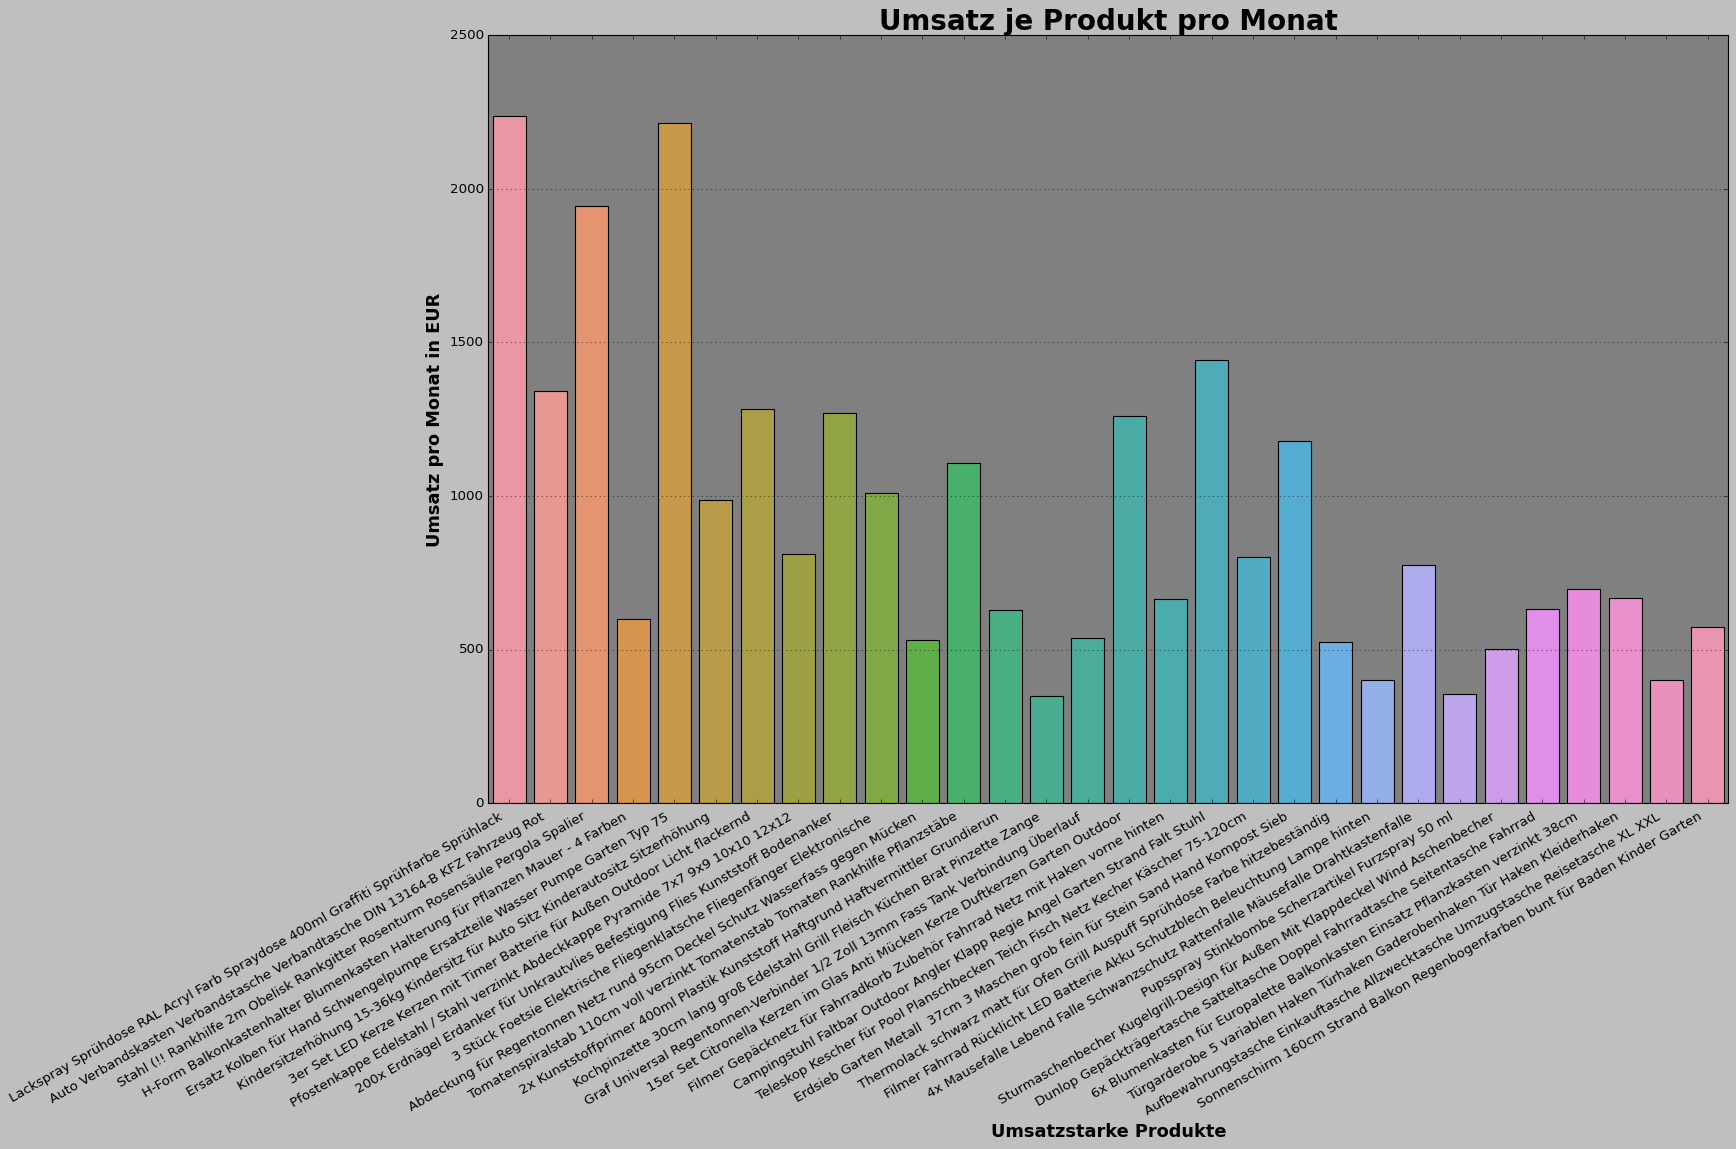

In [36]:
def plot_turnover_volume(df,num = 25,true_sales = True):
    """
    Plots the turnover volume for a specified number of products.
    """
    # Create a figure and axis
    fig,ax = plt.subplots(1,1,figsize=(20,12))
    
    # Adjust turnover based on true_sales flag
    df['Umsatz/Monat']= CFG.feedback_quote * df['Umsatz/Monat'] if true_sales else df['Umsatz/Monat']
    
    # Plot the bar chart
    ax = sns.barplot(data=df,y='Umsatz/Monat',x='Artikelname');
    
    # Set the axis labels and title
    ax.set_xlabel('Umsatzstarke Produkte',fontdict={'fontsize':16,'fontweight':'bold'})
    ax.set_ylabel('Umsatz pro Monat in EUR',fontdict={'fontsize':16,'fontweight':'bold'})
    ax.set_xticklabels(df.Artikelname, rotation = 30, ha="right");
    ax.set_title('Umsatz je Produkt pro Monat',fontdict={'fontsize':25,'fontweight':'bold'})
    ax.yaxis.grid()
    ax.set_facecolor('grey')
    # Save the plot
    plt.savefig(f'{CFG.path}/Umsatz je Produkt pro Monat(5).pdf',bbox_inches='tight')
    
plot_turnover_volume(best_selling_revenue)

In [37]:
def comparedplot(df,true_sales=True):
    """
    Generates a horizontal bar plot comparing sales data for different time periods.
    """
    # Select relevant columns for comparison
    bestsellings=df.set_index('Artikelname').loc[:,['Verkäufe letztes Monats in Stück',
                           'Durchschnittliche Verkäufe letzter 6 Monate',
                           'Durchschnittliche Verkäufe letzter 12 Monate']]
    
    # Scale sales data if true_sales is False
    bestsellings = bestsellings*CFG.feedback_quote if true_sales else bestsellings
    
    # Generate horizontal bar plot
    ax=bestsellings.plot(kind='barh',
                    figsize=(15,30),
                    color=['#0bff01','#fe0000','#fdfe02'],
                    edgecolor='black',
                    width=0.9,
                    alpha = 0.8
                    )

    plt.savefig(f'{CFG.path}/Verkaufsanzahlvergleich().pdf',bbox_inches='tight')
    

In [38]:
best_selling_revenue

,Artikel_link,Verkäufe letztes Monats in Stück,Verkäufe vor 1-6 Monat in Stück,Verkäufe vor 6-12 Monat in Stück,Durchschnittliche Verkäufe letzter 6 Monate,Durchschnittliche Verkäufe vor 6-12 Monat,Durchschnittliche Verkäufe letzter 12 Monate,Artikelname,Preis_EUR,Artikelnummer,Umsatz/Monat,Umsatz/6_Monate,Umsatz/12_Monate,Art_Name
0,https://www.ebay.de/itm/373937933433,88,366,283,73,47,59,Lackspray Sprühdose RAL Acryl Farb Spraydose 4...,10,373937933433,2238,4607,7495,Lackspray RAL Acryl
1,https://www.ebay.de/itm/232279934737,69,40,33,8,6,7,Auto Verbandskasten Verbandstasche Verbandtasc...,8,232279934737,1342,848,1136,Auto Verbandskasten Verbandstasche
2,https://www.ebay.de/itm/303052063711,50,107,93,21,16,18,Stahl (!! Rankhilfe 2m Obelisk Rankgitter Rose...,16,303052063711,1945,2412,3859,Stahl Rankhilfe Obelisk
3,https://www.ebay.de/itm/304430034393,48,82,53,16,9,12,H-Form Balkonkastenhalter Blumenkasten Halteru...,5,304430034393,600,639,898,Form Balkonkastenhalter Blumenkasten
4,https://www.ebay.de/itm/232291848140,41,45,35,9,6,7,Ersatz Kolben für Hand Schwengelpumpe Ersatzte...,22,232291848140,2215,1858,2550,Ersatz Kolben Hand
5,https://www.ebay.de/itm/371474696872,36,138,147,28,24,26,Kindersitzerhöhung 15-36kg Kindersitz für Auto...,11,371474696872,988,1932,3536,Kindersitz Auto Sitz
6,https://www.ebay.de/itm/234135245821,36,157,479,31,80,58,3er Set LED Kerze Kerzen mit Timer Batterie fü...,14,234135245821,1282,2724,9611,Set LED Kerze
7,https://www.ebay.de/itm/372695589382,34,98,188,20,31,26,Pfostenkappe Edelstahl / Stahl verzinkt Abdeck...,10,372695589382,810,1278,3053,Pfostenkappe Edelstahl Stahl
8,https://www.ebay.de/itm/304174144881,32,116,147,23,24,24,200x Erdnägel Erdanker für Unkrautvlies Befest...,16,304174144881,1270,2334,4700,Erdanker Unkrautvlies Befestigung
9,https://www.ebay.de/itm/302213467639,31,35,376,7,63,37,3 Stück Foetsie Elektrische Fliegenklatsche Fl...,13,302213467639,1010,861,5712,Foetsie Elektrische Fliegenklatsche


In [39]:
def short_item_name(text, words=3):
    
    #pattern=r'\b\w+\b' # pattern to find words
    pattern =r'\b[a-zA-Z]{3,20}\b'
    match = re.findall(pattern,text)
    text = ' '.join(match[:words]) # show only some words
    return text


best_selling_revenue['Art_Name'] = best_selling_revenue.Artikelname.apply(short_item_name)

In [47]:
def trend_comparedplot(bestsellers,true_sales=True):
    
    bestsellers=bestsellers.set_index('Artikelname').loc[:,['Verkäufe letztes Monats in Stück',
                           'Durchschnittliche Verkäufe letzter 6 Monate',
                           'Durchschnittliche Verkäufe letzter 12 Monate']]
    
    bestsellers = bestsellers*CFG.feedback_quote if true_sales else bestsellers
    ax=bestsellers.plot(kind='barh',
                    figsize=(15,30),
                    color=['#0bff01','#fe0000','#fdfe02'],
                    edgecolor='black',
                    width=0.9,
                    alpha = 0.3
                    ); 

    for i in range(len(bestsellers.index)):
        color1 ='g' if (bestsellers.iloc[i,1]>bestsellers.iloc[i,2]) else 'r' 
        color2= 'g' if (bestsellers.iloc[i,0]>bestsellers.iloc[i,1]) else 'r' 
        
        if not true_sales:
            ax.annotate('',xy =( bestsellers.iloc[i,1]*2,bestsellers.reset_index().index[i]),
                            xytext =(bestsellers.iloc[i,2]*2,bestsellers.reset_index().index[i]+0.3), 
                            arrowprops = dict(color =color1,
                                              arrowstyle='-',
                                              #width=1
                                             ))
            ax.annotate('',xy =( bestsellers.iloc[i,0]*2,bestsellers.reset_index().index[i]-0.3),
                            xytext =(bestsellers.iloc[i,1]*2,bestsellers.reset_index().index[i]), 
                            arrowprops = dict(color =color2,
                                              #arrowstyle='->',
                                             width=1
                                             ))  
        else:    
            ax.annotate('',xy =( bestsellers.iloc[i,1]/2,bestsellers.reset_index().index[i]),
                            xytext =(bestsellers.iloc[i,2]/2,bestsellers.reset_index().index[i]+0.3), 
                            arrowprops = dict(color =color1,
                                              arrowstyle='-',
                                              #width=1
                                             ))
            ax.annotate('',xy =( bestsellers.iloc[i,0]/2,bestsellers.reset_index().index[i]-0.3),
                            xytext =(bestsellers.iloc[i,1]/2,bestsellers.reset_index().index[i]), 
                            arrowprops = dict(color =color2,
                                              #arrowstyle='->',
                                             width=1
                                             ))
        ax.text(0.7, 0.94, ' --->' , 
                transform=ax.transAxes,color ='g',fontsize=18 )
        ax.text(0.76, 0.94, ' Nachfrage steigt', 
                transform=ax.transAxes,fontsize=15  )
        ax.text(0.7, 0.92, ' --->' , 
                transform=ax.transAxes,color ='r',fontsize=18 )
        ax.text(0.76, 0.92, ' Nachfrage sinkt', 
                transform=ax.transAxes,fontsize=15  )       

        plt.savefig(f'{CFG.path}/Verkaufstrend(3).pdf',bbox_inches='tight')
        
trend_comparedplot(best_selling_revenue,true_sales=CFG.real_sales)

SyntaxError: invalid syntax (1771101369.py, line 20)

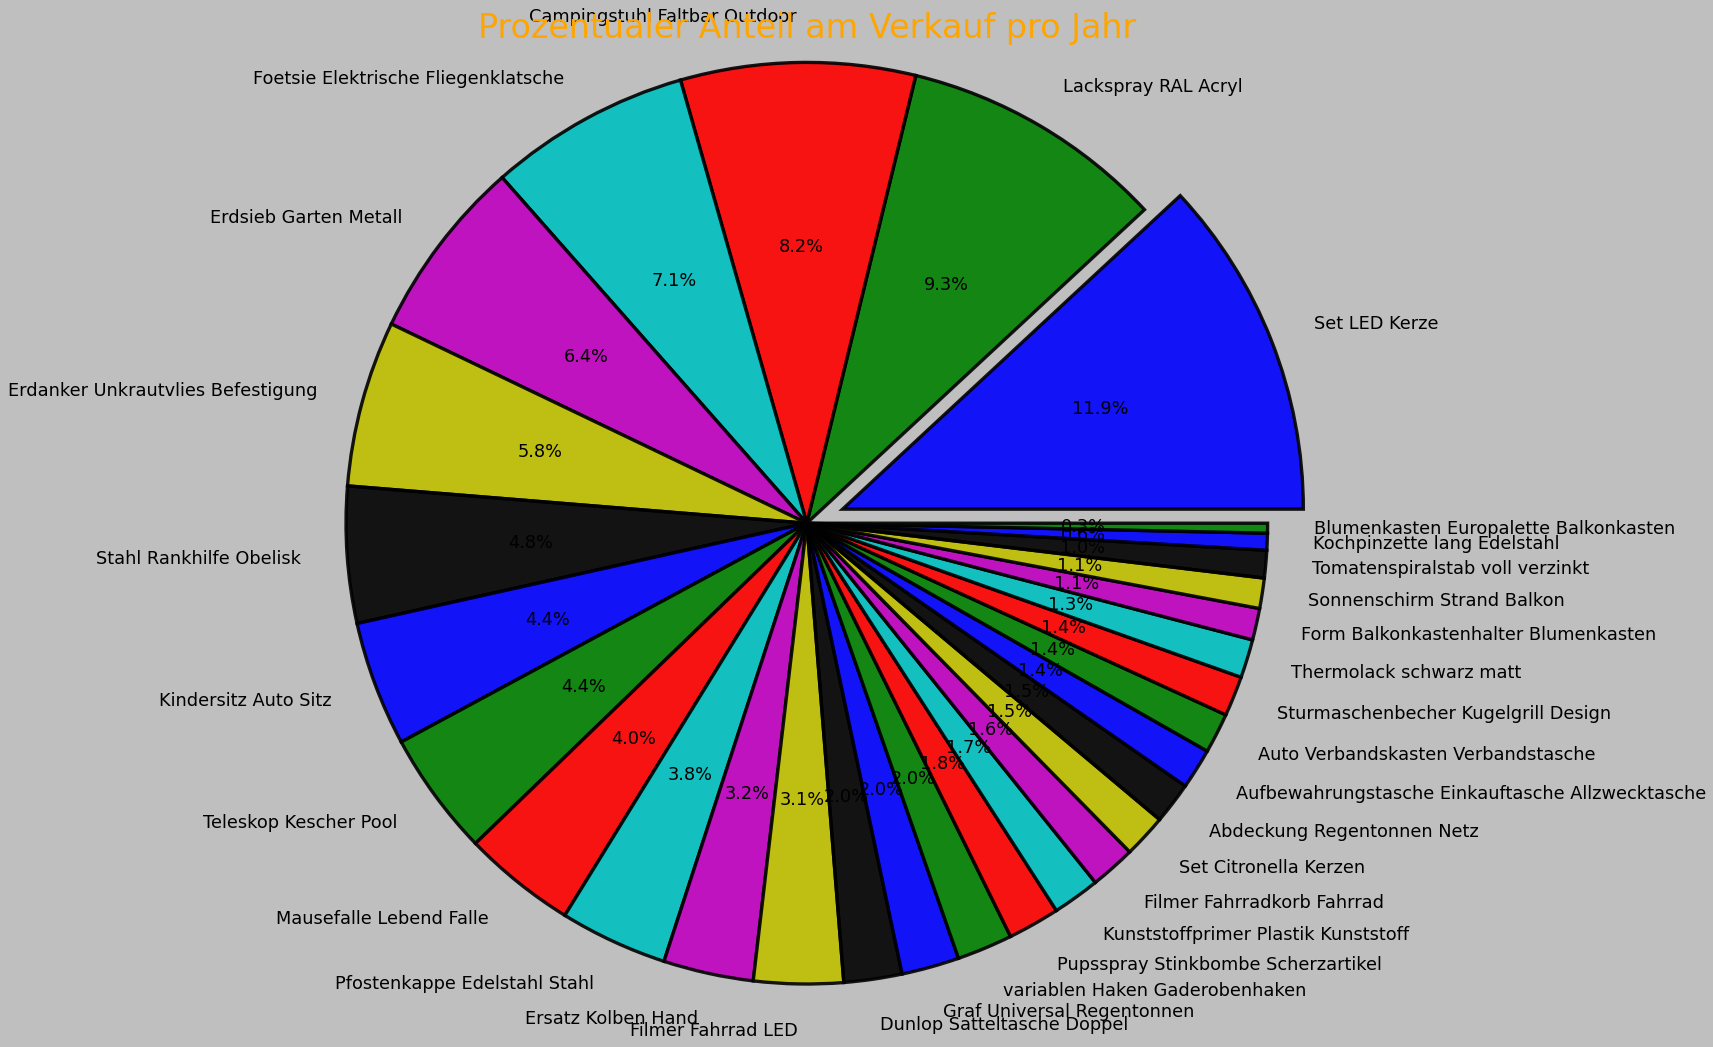

In [42]:
def plot_product_revenue(df,num=25):
    """
    Generates a pie chart showing the percentage contribution of products to total revenue.
    """
    
    # Create a figure and axis for the pie chart
    fig,ax = plt.subplots(1,1,figsize=(20,15))
    
    # Prepare explode array to highlight the first slice
    explode = np.zeros(num)
    explode[0]= 0.1
    
    # Sort the DataFrame by revenue and select the top products
    labels= df.sort_values('Umsatz/12_Monate',ascending=False)[:num].Art_Name
    
    # Generate the pie chart
    ax.pie(df['Umsatz/12_Monate'].sort_values(ascending=False)[:num],
                                                    labels=labels,
                                                    #shadow=True,
                                                    radius=1.2,
                                                    explode=explode,
                                                    autopct='%1.1f%%',
                                                    textprops={'fontsize':16,'color':'black' },
                                                    wedgeprops = {"alpha": 0.9,
                                                                 'linewidth': 3});
    # Set the title of the pie chart
    ax.set_title('Prozentualer Anteil am Verkauf pro Jahr',loc ='center', fontdict={'fontsize':30,'color':'orange'})
    
    # Save the plot
    plt.savefig(f'{CFG.path}/prozentualer Anteil am Verkauf(4).pdf',bbox_inches='tight')

plot_product_revenue(best_selling_revenue,num=CFG.num_bestsellings)

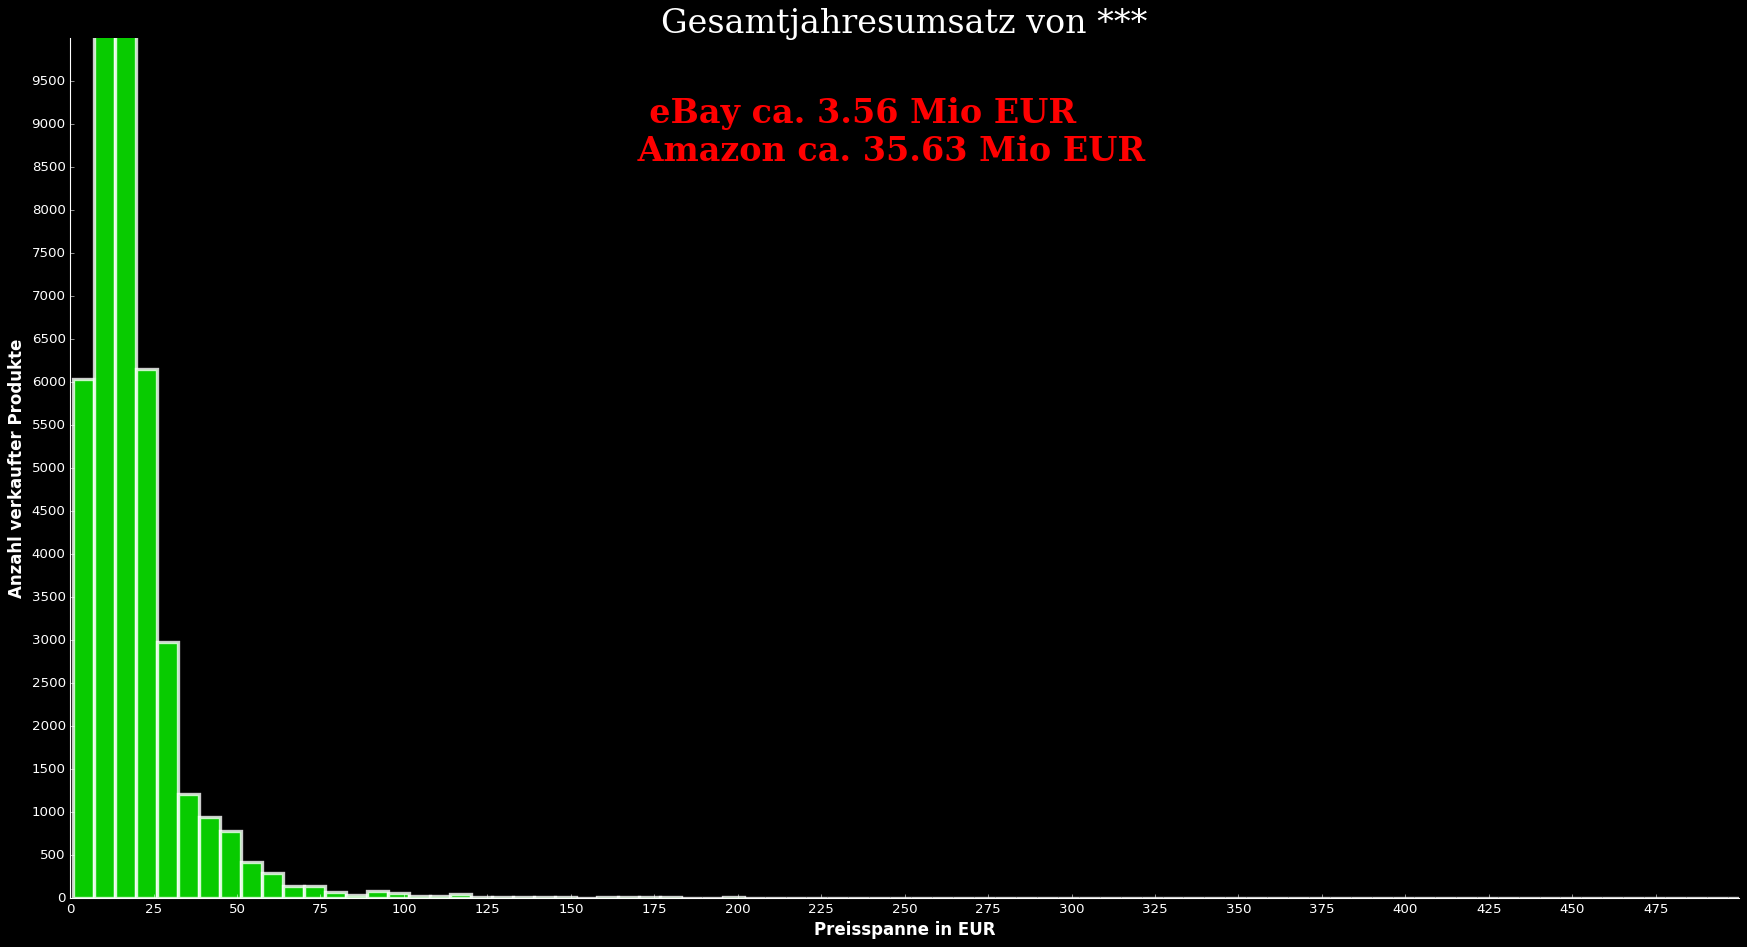

In [43]:
def plot_price_distribution(df,bins=200,x=500,y=10000):
    """
    Generates a histogram to visualize the distribution of prices in the given DataFrame.
    """
    
    plt.style.use('dark_background')
    fig,ax = plt.subplots(1,1,figsize=(22,12))
    ax.hist(df.Preis_EUR,bins=bins,color='#0bff01',alpha = 0.8, lw=3);
    ax.set_title(f'Gesamtjahresumsatz von ***', fontdict={'family': 'serif',
                                                        
                                                         'weight': 'normal',
                                                          'size': 30,
                                                          })
    ax.set_xlim(0,x)
    ax.set_xticks(range(0,x,int(x/20)))
    ax.set_xlabel("Preisspanne in EUR",fontweight='bold',fontsize=15)
    
    ax.set_ylim(0,y)
    ax.set_yticks(range(0,y,int(y/20)))
    ax.set_ylabel("Anzahl verkaufter Produkte",fontweight='bold',fontsize=15)
   
    ax.text(x/3,6*y/7,f'  eBay ca. {round(df.Preis_EUR.sum()*4/1000000,2) } Mio EUR \
                        \n Amazon ca. {round(df.Preis_EUR.sum()*40/1000000,2) } Mio EUR',
                                                        fontdict={'family': 'serif',
                                                         'color':  'red',
                                                         #'weight': 'normal',
                                                          'size': 30,
                                                          'fontweight':'bold'}) 
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.grid(False)
    plt.tick_params(
                    axis='both',       # changes apply to the x and y-axis
                    which='both',      # both major and minor ticks are affected
                    right=False,       # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    #labelbottom=False
                    ) 
    plt.tight_layout()
    plt.savefig(f'{CFG.path}/Gesamtumsatz(7).pdf',bbox_inches='tight')

plot_price_distribution(full_df)

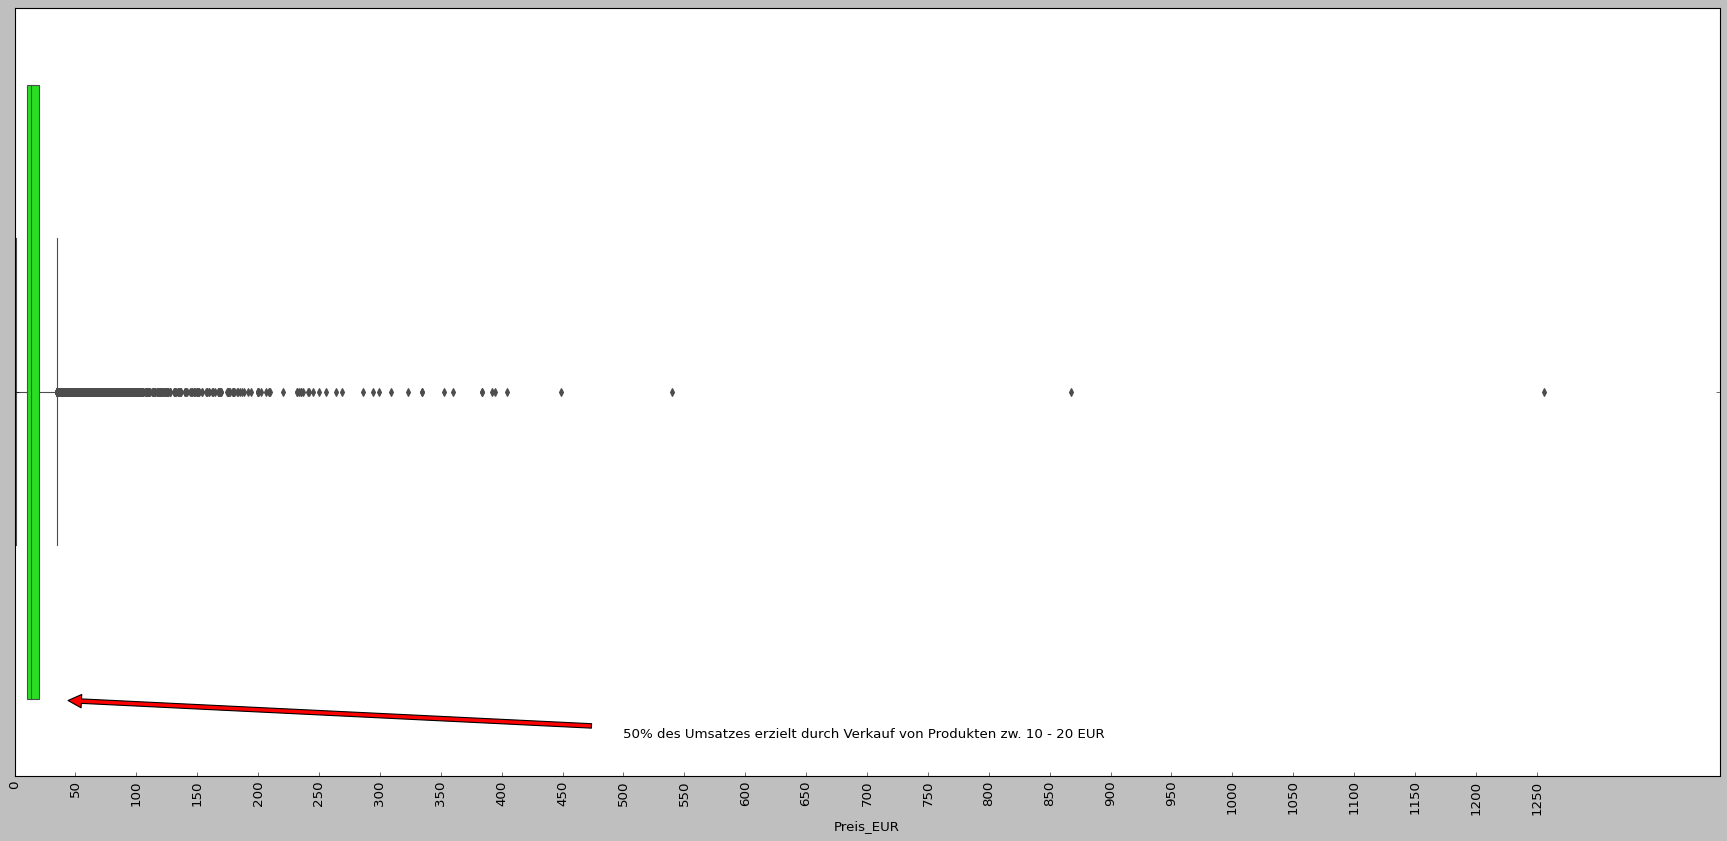

In [44]:
def plot_boxplot(df):
    """
    Generates a box plot to visualize the distribution of prices in a DataFrame.
    """
    
    plt.style.use('classic')
    fig,ax=plt.subplots(1,1,figsize=(27.5,12))
    ax = sns.boxplot(data=df,x='Preis_EUR',color='#0bff01')
    
    quantile_1=round(df.Preis_EUR.quantile(0.25))
    quantile_3=round(df.Preis_EUR.quantile(0.75))
    
                                
    ax.set_xticks(range(0,round(df.Preis_EUR.max()/100)*100,50))
    ax.annotate(f'50% des Umsatzes erzielt durch Verkauf von Produkten zw. {quantile_1} - {quantile_3} EUR ',
                xy =(quantile_3, 0.4),
                xytext =(500, 0.45), 
                arrowprops = dict(facecolor ='red',
                                  shrink = 0.05),)
    plt.xticks(rotation=90);
    plt.tick_params(
                    axis='x',          
                    which='both',           
                    top=False,         
                   ) 
    plt.savefig(f'{CFG.path}/Preisspanne die 50% Umsatz generiert(8).pdf',bbox_inches='tight')
    
plot_boxplot(full_df)

In [45]:
def create_corpus(df):
    corpus=[]
    
    for x in df['Artikelname'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

def get_bestselling_brand(df,true_sales=True):
    
    german_stopwords=[word.upper() for word in CFG.german_stopwords] + CFG.more_stopwords
    
    df.Artikelname=df.Artikelname.apply(short_item_name,10)
    corpus=create_corpus(df)
    corpus=[word.upper() for word in corpus]
    words_series=pd.Series(corpus)
  
    words_series=words_series.value_counts(ascending=False)[:]
    words_series.drop(labels=german_stopwords,errors='ignore',inplace=True)
    mostfrequent_words = words_series.head(30)
    most_revenues={}
    for i in range(len(mostfrequent_words)):

        product=mostfrequent_words.index[i]
        total =df.loc[df.Artikelname.str.upper().str.contains(product),'Preis_EUR'].sum()
        most_revenues[product]=round(total)
    
    most_revenue_brands=pd.DataFrame(most_revenues.items(),columns=['Marke/Produkt','Total_Verkaufsumme'])
    most_revenue_brands['Total_Verkaufsumme'] = 4*most_revenue_brands['Total_Verkaufsumme'] if true_sales else most_revenue_brands['Total_Verkaufsumme']
    
    return most_revenue_brands

bestselling_brands = get_bestselling_brand(full_df,true_sales=True)


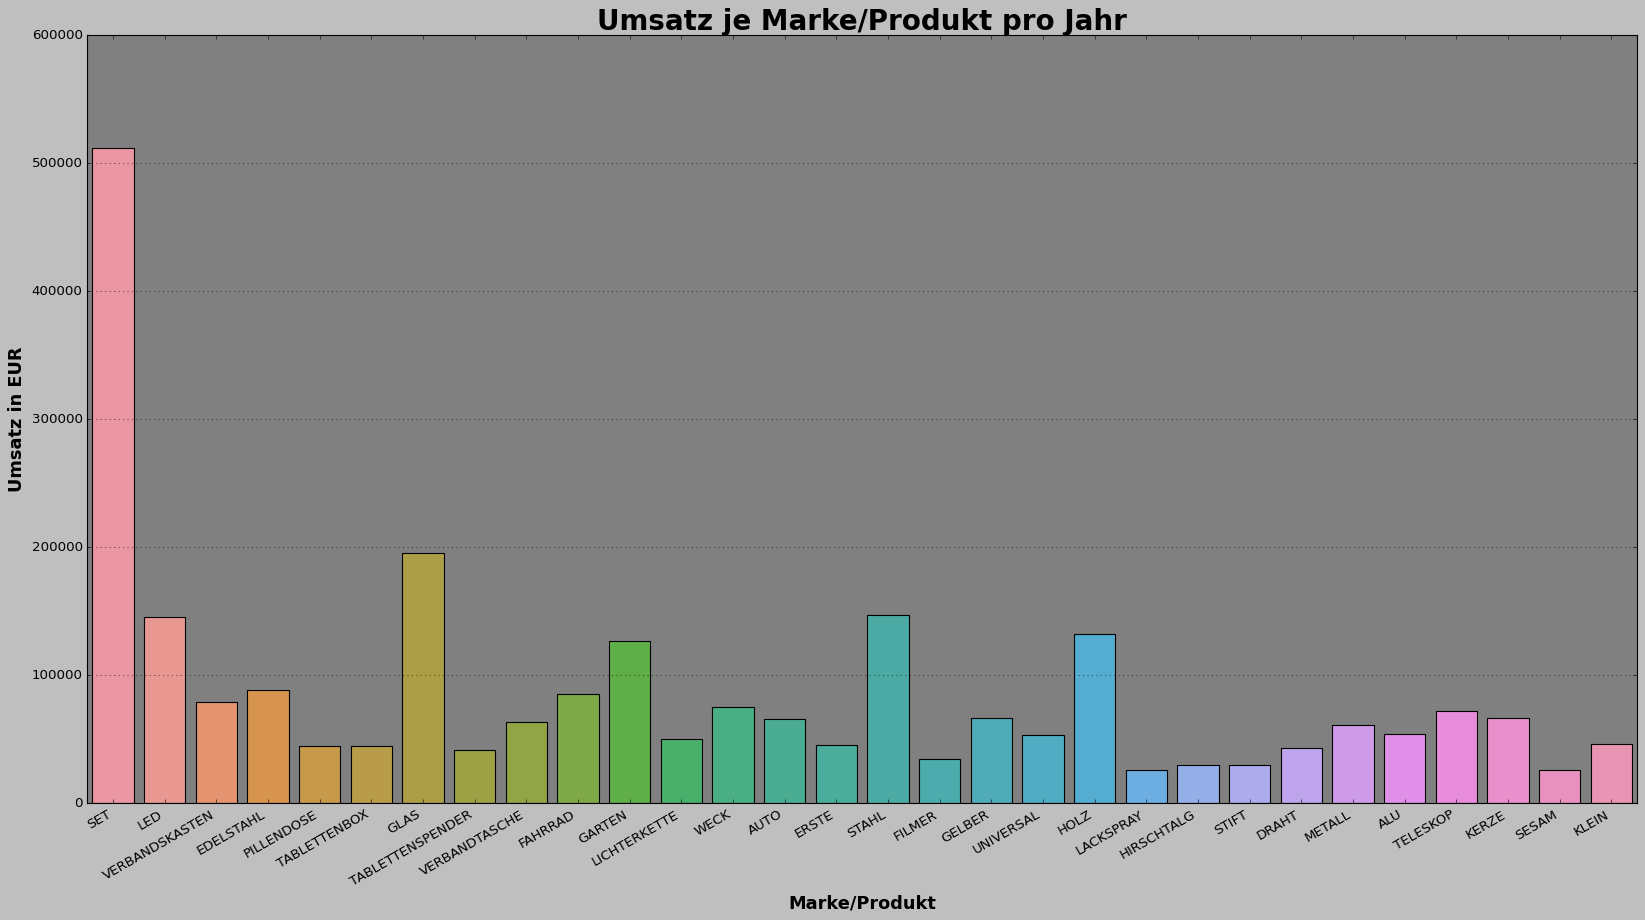

In [25]:
def plot_bestbrands(df,true_sales=True):
    """
    Plots the bar chart showing the sales revenue for the best brands/products per year.
    """
    
    fig,ax = plt.subplots(1,1,figsize=(25,12))
    ax = sns.barplot(data=df,
                y='Total_Verkaufsumme',x='Marke/Produkt');
    ax.set_xlabel('Marke/Produkt',fontdict={'fontsize':16,'fontweight':'bold'})
    ax.set_ylabel('Umsatz in EUR',fontdict={'fontsize':16,'fontweight':'bold'})
    ax.set_xticklabels(df['Marke/Produkt'], rotation = 30, ha="right");
    ax.set_title('Umsatz je Marke/Produkt pro Jahr',fontdict={'fontsize':25,'fontweight':'bold'})
    ax.yaxis.grid()
    ax.set_facecolor('grey')
    
    plt.savefig(f'{CFG.path}/Umsatz je Marke-Produkt pro Jahr(6).pdf',bbox_inches='tight')
    
plot_bestbrands(bestselling_brands)

In [26]:
def merge_pdfs(source_dir,shop=''):
    
    merger = PdfMerger()
    files = os.listdir(source_dir)
    pdfs = [file for i in range(len(files)) for file in files if ('('+ str(i+1)+')') in file and file.endswith('pdf')]
    for pdf in pdfs:
        #if pdf.endswith('pdf'):
        merger.append(source_dir +'/'+ pdf)

    merger.write(source_dir + f'/Verkaufsanalyse_von_{shop}.pdf')       
    merger.close()

    if sys.platform:

        subprocess.Popen(['open',f'{CFG.path}/{CFG.shop_name}_{CFG.num_bestsellings}_bestsellings.csv'])

        time.sleep(1)
        subprocess.Popen(['open',f'{CFG.path}/Verkaufsanalyse_von_{CFG.shop_name}.pdf'])

    
merge_pdfs(f"Verkaufsanalyse_{CFG.shop_name}",shop=CFG.shop_name)

In [24]:
xytext_x = CFG.get_text_position(CFG.shop_category)

In [27]:
if CFG.email:
    password ='!Eli***33oG' # input('Password eingeben: ') #'!El***33oG'
def send_email_with_attachment(password, receiver='***@gmail.com', files=[],
              server="smtp.gmail.com", port=587,
              use_tls=True,shop=''):
    
    import smtplib
    from CFG.pathlib import CFG.path
    from email.mime.multipart import MIMEMultipart
    from email.mime.base import MIMEBase
    from email.mime.text import MIMEText
    from email.utils import COMMASPACE, formatdate
    from email import encoders

    send_from='isaaacduong@gmail.com'
    msg = MIMEMultipart()
    msg['From'] = send_from
    #msg['To'] = COMMASPACE.join(send_to)
    #msg['To'] = send_to
    
    msg['Date'] = formatdate(localtime=True)
    msg['Subject'] = f'Verkaufsanalyse' 
    message = f'Hallo, hier ist nochmals die Verkaufsanalyse von dem ebay shop {shop}\n\n'

    msg.attach(MIMEText(message))

    for CFG.path in files:
        part = MIMEBase('application', "octet-stream")
        with open(CFG.path, 'rb') as file:
            part.set_payload(file.read())
        encoders.encode_base64(part)
        part.add_header('Content-Disposition',
                        'attachment; filename={}'.format(CFG.path(CFG.path).name))
        msg.attach(part)

    smtp = smtplib.SMTP(server, port)
    if use_tls:
        smtp.starttls()
    smtp.login(send_from, password)
    smtp.sendmail(send_from, receiver, msg.as_string())
    smtp.quit()
if email:
    files=[f'Verkaufsanalyse_von_{CFG.shop_name}.pdf',f'{CFG.shop_name}_{CFG.num_bestsellings}_bestsellings.csv']
    files_CFG.paths = [CFG.path +"/"+ file for file in files]
    send_email_with_attachment(password=password, files=files_CFG.paths,shop=CFG.shop_name)

SyntaxError: invalid syntax (2497327802.py, line 8)

In [ ]:
#bins=100
#bins=150
bins=categories[shop_category]['bins']
x_max=df.Preis_EUR.max()/categories[shop_category]['x_max_rate']
y_max=categories[shop_category]['y_max_rate']*bins**2
plot_price_distribution(df,bins=bins,y=round(y_max),x=round(x_max))
plot_turnover_volume(best_selling_revenue) 